# Testing Tabular SR

In [115]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [116]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import partial
from IPython.display import clear_output

%matplotlib inline

In [117]:
def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label='Mean return')
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

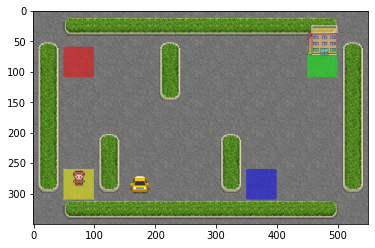

In [118]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset(seed=13)
plt.imshow(env.render())

## Q-learning

In [119]:
class DecayVal:
    val: float
    decay: float
    schedule: int
    def __init__(self, val, decay, schedule):
        self.val = val
        self.decay = decay
        self.i = 0
        self.schedule = schedule

    def __call__(self):
        return self.val

    def step(self):
        self.i += 1
        if self.i % self.schedule == 0:
            self.val *= self.decay


class QAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)

    def reset(self):
        self.eps.step()
        self.lr.step()
        
    def act(self, s):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps():
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, done):
        # реализуйте шаг Q-обучения
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        Q_s_a = self.Q[s, a]
        V_sn = np.max(self.Q[s_n])

        td_error = r + self.gamma * (1-done) * V_sn - Q_s_a
        self.Q[s, a] += self.lr() * td_error

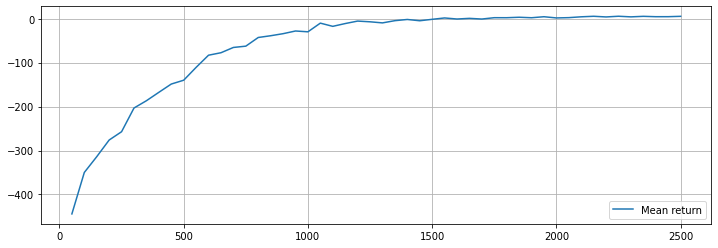

Episode: 2500, Return: -2, AvgReturn[50]: 5


(0.04669747052543716, 0.03221225472000002)

In [120]:
def train(env, agent, n_episodes, seed, show_progress_schedule=50):
    avg_returns, returns_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(1, n_episodes+1):
        state, _ = env.reset(seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)

            # выполняем действие в среде
            next_state, reward, terminated, truncated, info = env.step(action)
            # шаг обучения
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            episode_return += reward
            done = terminated or truncated
            if done:
                agent.reset()
                break

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0:
            avg_returns.append((i, np.mean(returns_batch)))
            returns_batch = []
            
            show_progress(avg_returns)
            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
            )

    return avg_returns

env = gym.make("Taxi-v3")
seed = 1337
agent = QAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
)

log_q = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

In [121]:
def encode(taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i
    
def decode(i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        #print(i, 'AAAAAAAAAAAAAAA')
        #assert 0 <= i < 5
        #assert (0 <= i < 5).all
        state_extended = []
        for i in reversed(out):
            state_extended.append(i)
        return state_extended   

In [122]:
for s in range(500):
    

SyntaxError: unexpected EOF while parsing (1054796220.py, line 2)

In [ ]:
print(agent.Q)
print(agent.Q.shape)

In [ ]:
#Results analysis

In [ ]:
state_seed_dict = {}
for t_x in range(5):
    for t_y in range(5):
        for pas_loc in range(5):
            for dest_loc in range(4):
                state_seed_dict[(t_x, t_y, pas_loc, dest_loc)] = []
print(state_seed_dict)

for seed in range(500):
    state, _ = env.reset(seed=seed)
    t_x, t_y, pas_loc, dest_loc = decode(state)
    state_seed_dict[(t_x, t_y, pas_loc, dest_loc)].append(seed)

    
print(state_seed_dict)

2 4 1 0


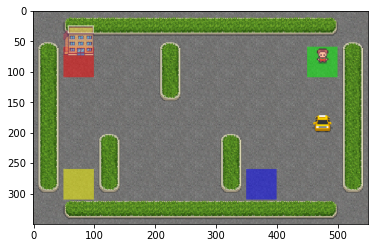

In [123]:
#reset only once
env=gym.make('Taxi-v3', render_mode = 'rgb_array')
state, _ = env.reset(seed=87)
plt.imshow(env.render())

T_X, T_Y, PAS_LOC, DEST_LOC = decode(state)
print(T_X, T_Y, PAS_LOC, DEST_LOC)
#env.close()

In [164]:
print(env.desc)

[[b'+' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'+']
 [b'|' b'R' b':' b' ' b'|' b' ' b':' b' ' b':' b'G' b'|']
 [b'|' b' ' b':' b' ' b'|' b' ' b':' b' ' b':' b' ' b'|']
 [b'|' b' ' b':' b' ' b':' b' ' b':' b' ' b':' b' ' b'|']
 [b'|' b' ' b'|' b' ' b':' b' ' b'|' b' ' b':' b' ' b'|']
 [b'|' b'Y' b'|' b' ' b':' b' ' b'|' b'B' b':' b' ' b'|']
 [b'+' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'+']]


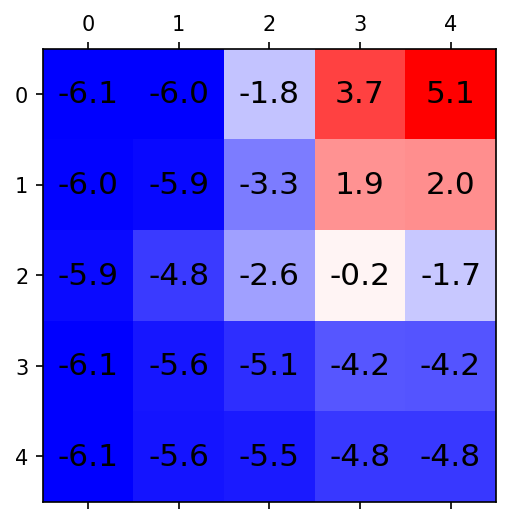

In [92]:
fig, ax = plt.subplots(dpi=150)
#state = [t_x, t_y, pas_loc, dest_loc]

V = np.zeros((5,5)) + np.inf
for t_x in range(5):
    for t_y in range(5):
        state = encode(t_x,t_y, PAS_LOC, DEST_LOC)
        #print(agent.Q[state,:])
        V[t_x, t_y] = np.max(agent.Q[state,:])
        v = V[t_x, t_y]
        ax.text(t_y, t_x, str(round(v, 1)), va='center', ha='center', fontsize=15) 
    
ax.matshow(V, cmap='bwr')

In [132]:
def encode(taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i
    
def decode(i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        #print(i, 'AAAAAAAAAAAAAAA')
        #assert 0 <= i < 5
        #assert (0 <= i < 5).all
        state_extended = []
        for i in reversed(out):
            state_extended.append(i)
        return state_extended 

def calc_value_matrix(Q, PAS_LOC, DEST_LOC, grid_dim_x = 5, grid_dim_y = 5):
    #we fix passenger location and destination location and go inside the environment
    #initialize V
    V = np.zeros((grid_dim_x, grid_dim_y)) + np.inf
    
    #go inside the grid and calculate V
    for t_x in range(grid_dim_x):
        for t_y in range(grid_dim_y):
            state = encode(t_x,t_y, PAS_LOC, DEST_LOC) 
            V[t_x, t_y] = np.max(Q[state,:])
    return V

def plot_value_matrix(V):
    fig, ax = plt.subplots(dpi=150)
    #initialize
    for t_x in range(V.shape[0]):
        for t_y in range(V.shape[1]):
            v = V[t_x, t_y]
            ax.text(t_y, t_x, str(round(v, 1)), va='center', ha='center', fontsize=15) 
    ax.matshow(V, cmap='bwr')
    plt.show()
    
def plot_value_field(agent, PAS_LOC, DEST_LOC, grid_dim_x = 5, grid_dim_y = 5):
    #we fix passenger location and destination location and go inside the environment 
    fig, ax = plt.subplots(dpi=150)

    #initialize 
    V = np.zeros((grid_dim_x, grid_dim_y)) + np.inf
    for t_x in range(grid_dim_x):
        for t_y in range(grid_dim_y):
            state = encode(t_x,t_y, PAS_LOC, DEST_LOC)
            #print(agent.Q[state,:])
            V[t_x, t_y] = np.max(agent.Q[state,:])
            v = V[t_x, t_y]
            ax.text(t_y, t_x, str(round(v, 1)), va='center', ha='center', fontsize=15) 

    ax.matshow(V, cmap='bwr')

[[-6.09160861 -6.04774227 -1.77041032  3.69072371  5.14597779]
 [-6.00581194 -5.89245668 -3.34162701  1.92668061  1.99457347]
 [-5.86568027 -4.80434226 -2.56616566 -0.22542564 -1.66628726]
 [-6.05145877 -5.57983035 -5.06983347 -4.19157804 -4.22082494]
 [-6.0864709  -5.61477861 -5.51856366 -4.83050813 -4.82206196]]


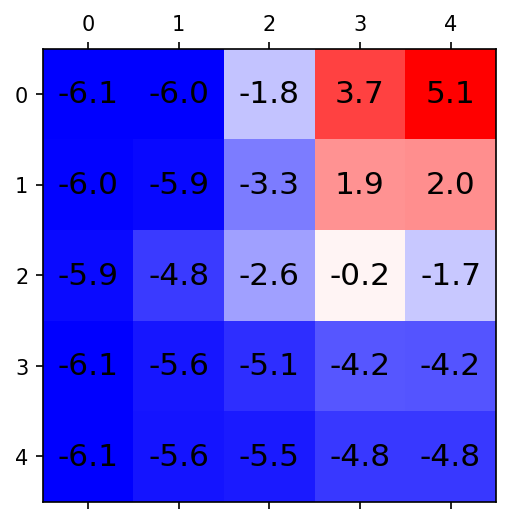

In [133]:
V = calc_value_matrix(agent.Q, PAS_LOC, DEST_LOC, grid_dim_x = 5, grid_dim_y = 5)
print(V)
plot_value_matrix(V)

In [ ]:
print(a)

In [18]:
print(agent.Q[state,:])

[-4.29991566 -1.66628726 -4.25053372 -4.23179468 -7.56253108 -8.32268316]


## SR

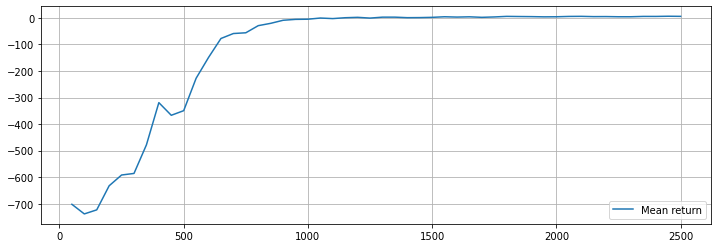

Episode: 2500, Return: 6, AvgReturn[50]: 6


(0.04669747052543716, 0.03221225472000002)

In [165]:
class SrAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, seed, sarsa=False):
        self.r = np.zeros((n_states,))
        self.M = np.zeros((n_states, n_actions, n_states))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self.sarsa = sarsa
        self._rng = np.random.default_rng(seed)

    def reset(self):
        self.eps.step()
        self.lr.step()

    def Q(self, s):
        return np.dot(self.M[s], self.r)
        
    def act(self, s, greedy=False):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if not greedy and self._rng.random() < self.eps():
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q(s))  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, done):
        # реализуйте шаг Q-обучения
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        self.r[s_n] += self.lr() * (r - self.r[s_n])

        # do I need max(M)?
        a_n = self.act(s_n, greedy=not self.sarsa)

        target = self.gamma * (1 - done) * self.M[s_n, a_n]
        target[s_n] += 1.
        
        td_error = target - self.M[s,a]
        self.M[s, a] += self.lr() * td_error

env = gym.make("Taxi-v3")
seed = 1337
agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
    sarsa=False
)

log_q_sr = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

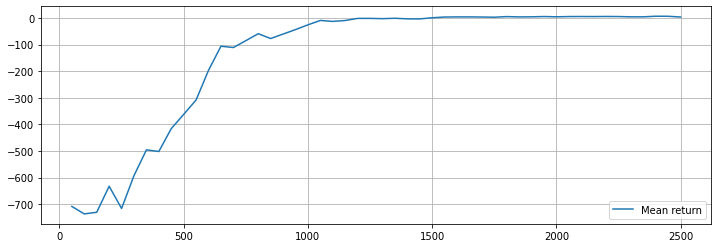

Episode: 2500, Return: 8, AvgReturn[50]: 4


(0.04669747052543716, 0.03221225472000002)

In [166]:
env = gym.make("Taxi-v3")
seed = 1337
agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
    sarsa=True
)

log_sarsa_sr = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

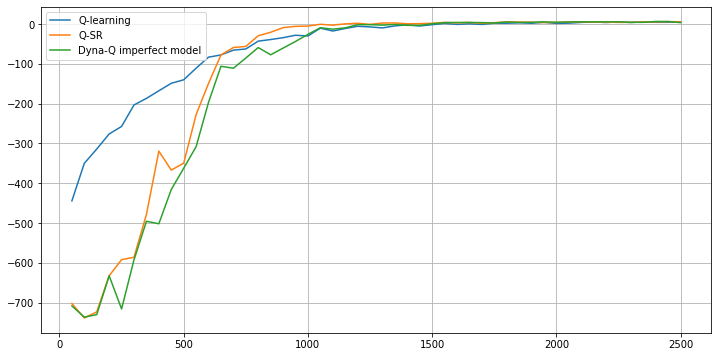

In [167]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_q_sr, 'Q-SR'),
    (log_sarsa_sr, 'Dyna-Q imperfect model'),
])

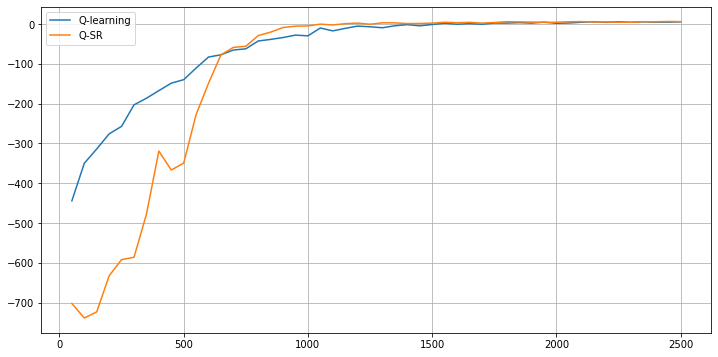

In [168]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_q_sr, 'Q-SR'),
    #(log_sarsa_sr, 'Dyna-Q imperfect model'),
])

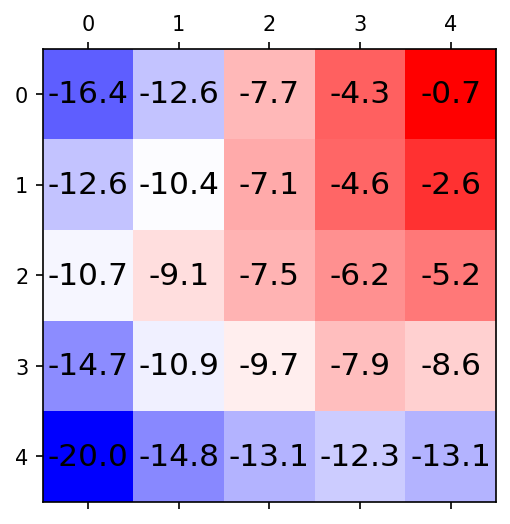

In [169]:
fig, ax = plt.subplots(dpi=150)
#state = [t_x, t_y, pas_loc, dest_loc]

V = np.zeros((5,5)) + np.inf #initialize
for t_x in range(5):
    for t_y in range(5):
        state = encode(t_x,t_y, PAS_LOC, DEST_LOC)
        #print(agent.Q[state,:])
        V[t_x, t_y] = np.max(agent.Q(state))
        v = V[t_x, t_y]
        ax.text(t_y, t_x, str(round(v, 1)), va='center', ha='center', fontsize=15) 
    
ax.matshow(V, cmap='bwr')

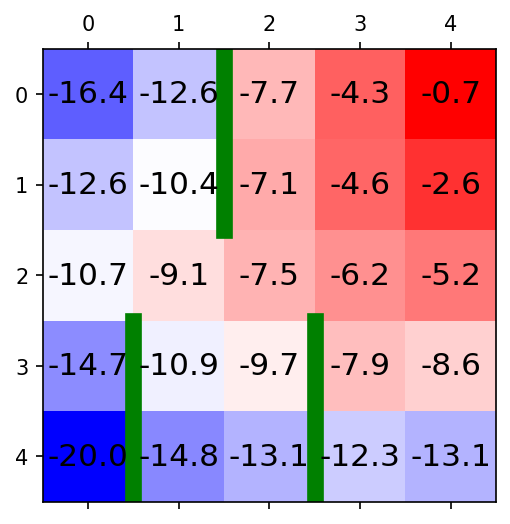

In [187]:
fig, ax = plt.subplots(dpi=150)
#state = [t_x, t_y, pas_loc, dest_loc]

V = np.zeros((5,5)) + np.inf #initialize
for t_x in range(5):
    for t_y in range(5):
        state = encode(t_x,t_y, PAS_LOC, DEST_LOC)
        #print(agent.Q[state,:])
        V[t_x, t_y] = np.max(agent.Q(state))
        v = V[t_x, t_y]
        ax.text(t_y, t_x, str(round(v, 1)), va='center', ha='center', fontsize=15) 
        
        
ax.axvline(x = 1-0.5, ymax = 0.4,  color = 'green', label = 'axvline - full height', linewidth =8)
ax.axvline(x = 2-0.5, ymin = 0.6,  color = 'green', label = 'axvline - full height', linewidth =8)
ax.axvline(x = 3-0.5, ymax = 0.4,  color = 'green', label = 'axvline - full height', linewidth =8)
    
ax.matshow(V, cmap='bwr')



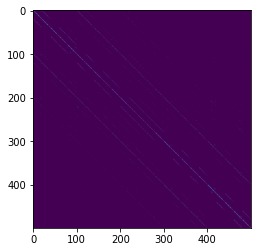

In [140]:
averaged_M = np.mean(agent.M, axis=1) #500 6 500
plt.imshow(averaged_M)

In [141]:
print(agent.M.shape)
print(averaged_M.shape)

(500, 6, 500)
(500, 500)


In [145]:
#make a matrix with states of interest
states_of_interest = []
for i in range(500):
    t_x, t_y, pas_loc, dest_loc = decode(i)
    if pas_loc== PAS_LOC and dest_loc == DEST_LOC:
        states_of_interest.append(i)

In [147]:
print(states_of_interest)
print(len(states_of_interest))

[4, 24, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404, 424, 444, 464, 484]
25


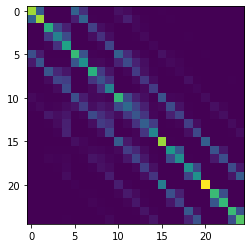

In [150]:
M_fixed = averaged_M[states_of_interest, :][:, states_of_interest]
plt.imshow(M_fixed)

TypeError: argument of type 'int' is not iterable

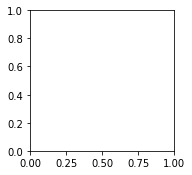

In [157]:
grid_size = 5
state_size = 25

#averaged_M = np.reshape(averaged_M, [state_size, grid_size, grid_size])
M_fixed = np.reshape(M_fixed, [state_size, grid_size, grid_size])

cmap = plt.cm.viridis
cmap.set_bad(color='white')

def mask_grid(grid, blocks, mask_value=-100):
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if [i,j] in blocks:
                grid[i,j] = mask_value
    grid = np.ma.masked_where(grid == mask_value, grid)
    return grid

plt.figure(1, figsize=(grid_size*3, grid_size*3))
for i in range(state_size):
    #if env.state_to_point(i) not in env.blocks:
        ax = plt.subplot(grid_size, grid_size, i + 1)
        ax.imshow(mask_grid(M_fixed[i,:],5), cmap=cmap)

In [ ]:
grid_size = 5
state_size = 25

#averaged_M = np.reshape(averaged_M, [state_size, grid_size, grid_size])
M_fixed = np.reshape(M_fixed, [state_size, grid_size, grid_size])

cmap = plt.cm.viridis
cmap.set_bad(color='white')

def mask_grid(grid, blocks, mask_value=-100):
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if [i,j] in blocks:
                grid[i,j] = mask_value
    grid = np.ma.masked_where(grid == mask_value, grid)
    return grid

plt.figure(1, figsize=(grid_size*3, grid_size*3))
for i in range(state_size):
    #if env.state_to_point(i) not in env.blocks:
        ax = plt.subplot(grid_size, grid_size, i + 1)
        ax.imshow(mask_grid(M_fixed[i,:],5), cmap=cmap)

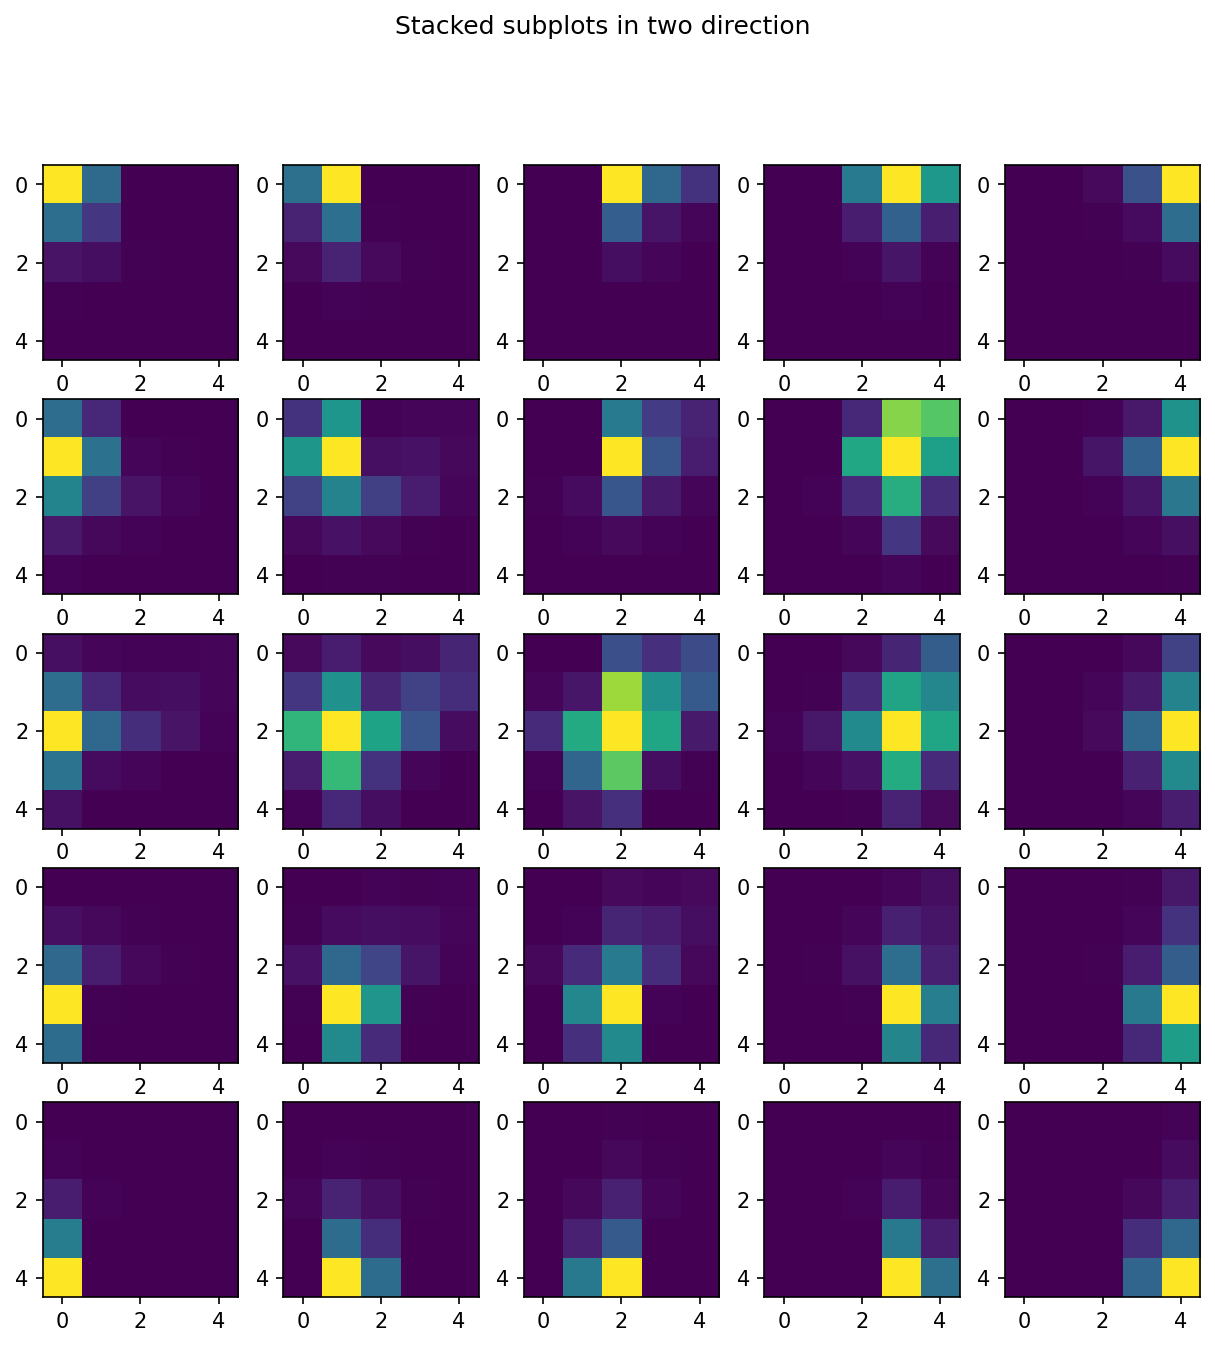

In [160]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize = (10,10), dpi = 150)
 
#fig.suptitle('Stacked subplots in two direction')

for i in range(5):
    for j in range(5):
        sr_t = M_fixed[i*5+j,:].reshape(-1,5)
        ax[i,j].imshow(sr_t)
plt.show()

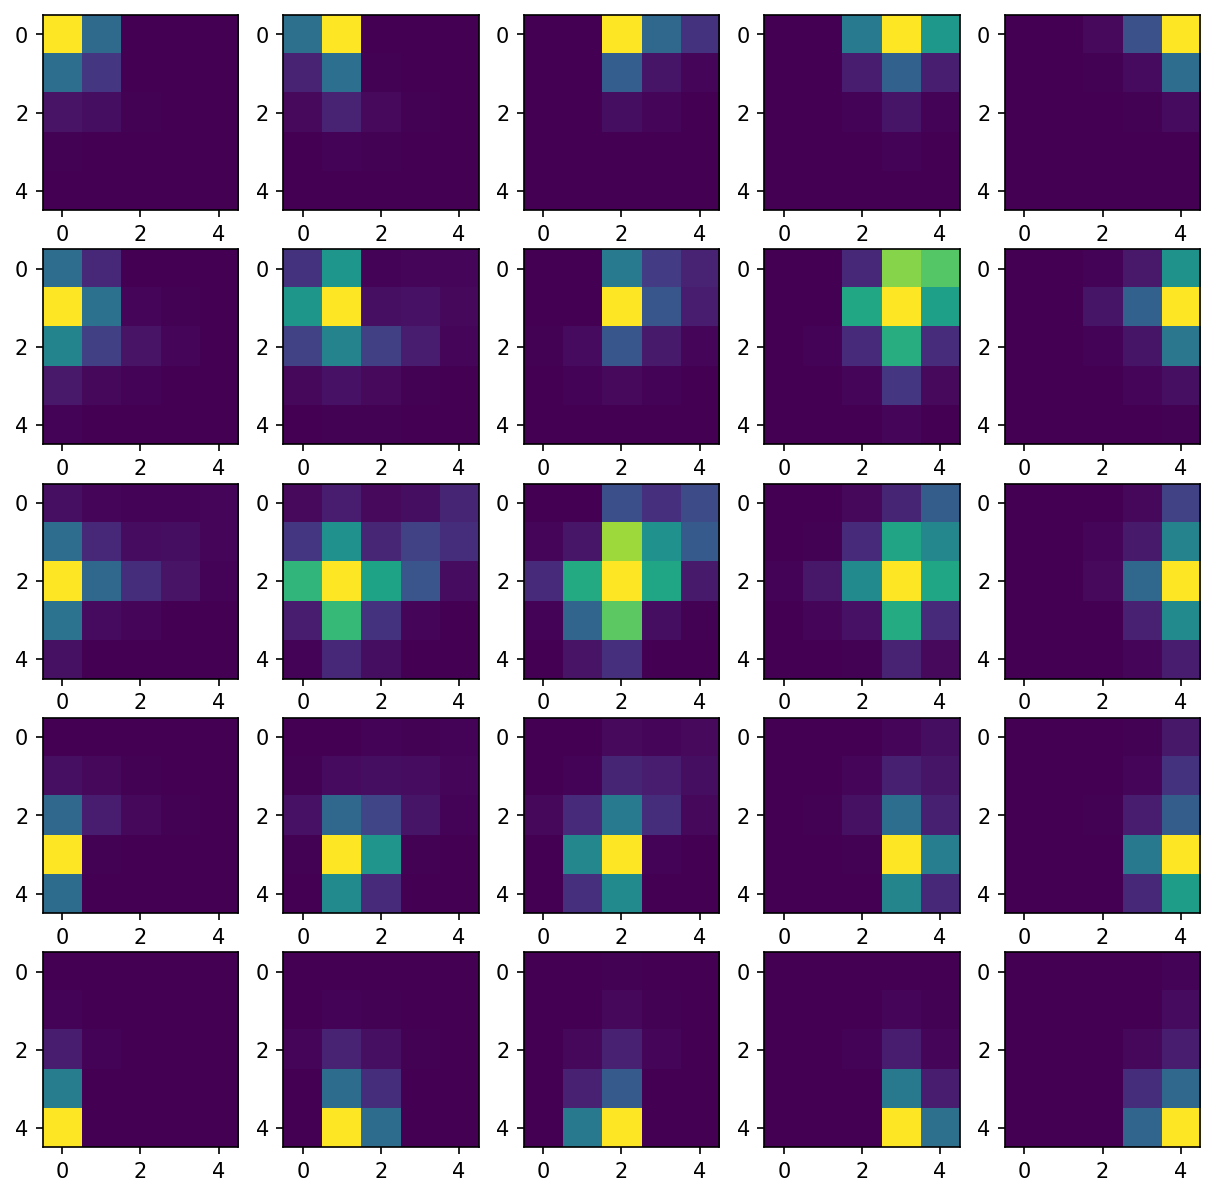

In [211]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize = (10,10), dpi = 150)
 
#fig.suptitle('Stacked subplots in two direction')

for i in range(5):
    for j in range(5):
        sr_t = M_fixed[i*5+j,:].reshape(-1,5)
        ax[i,j].imshow(sr_t)
plt.show()

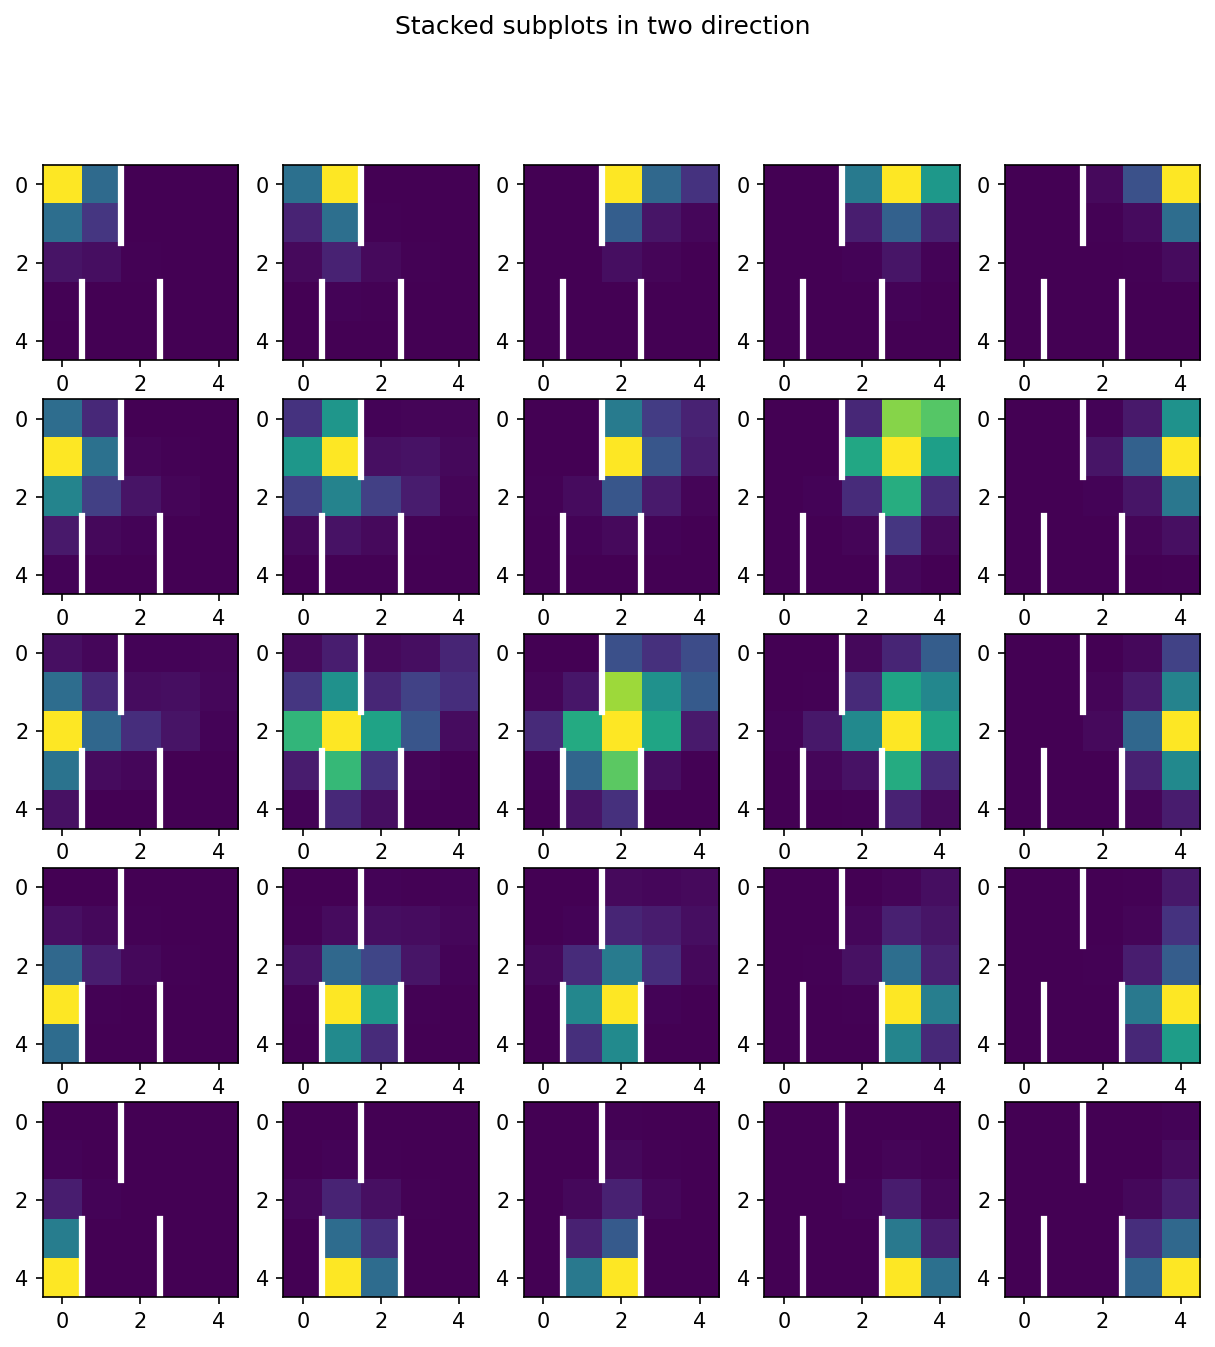

In [188]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize = (10,10), dpi = 150)
 
fig.suptitle('Stacked subplots in two direction')

for i in range(5):
    for j in range(5):
        sr_t = M_fixed[i*5+j,:].reshape(-1,5)
        ax[i,j].imshow(sr_t)
        ax[i,j].axvline(x = 1-0.5, ymax = 0.4,  color = 'white', label = 'axvline - full height', linewidth =3)
        ax[i,j].axvline(x = 2-0.5, ymin = 0.6,  color = 'white', label = 'axvline - full height', linewidth =3)
        ax[i,j].axvline(x = 3-0.5, ymax = 0.4,  color = 'white', label = 'axvline - full height', linewidth =3)
plt.show()



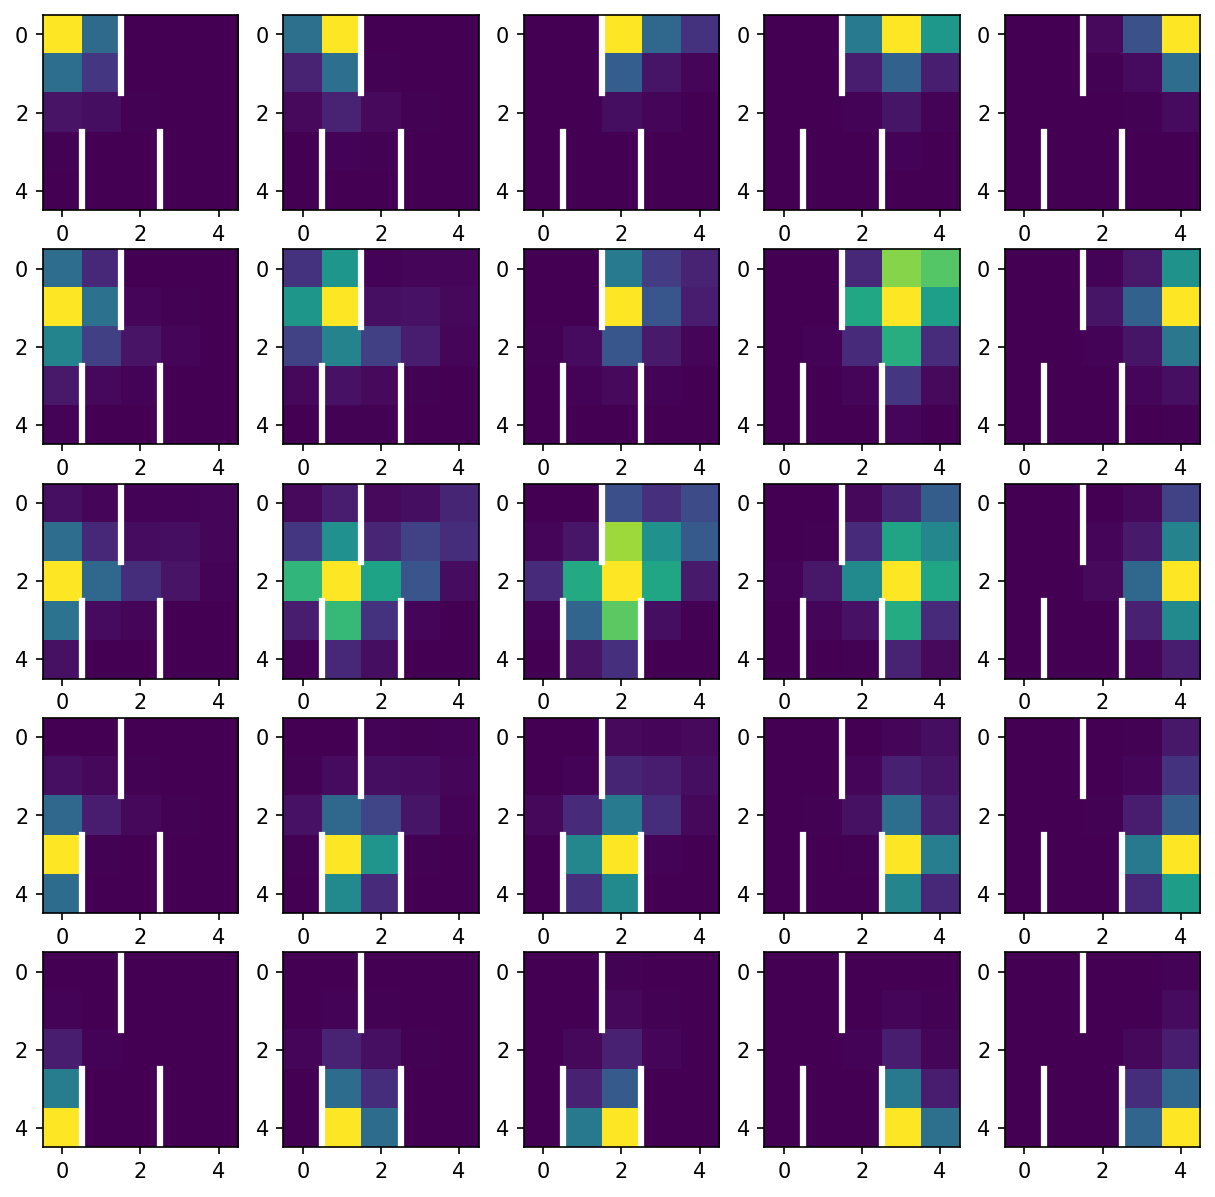

In [212]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize = (10,10), dpi = 150)

for i in range(5):
    for j in range(5):
        sr_t = M_fixed[i*5+j,:].reshape(-1,5)
        ax[i,j].imshow(sr_t)
        ax[i,j].axvline(x = 1-0.5, ymax = 0.4,  color = 'white', label = 'axvline - full height', linewidth =3)
        ax[i,j].axvline(x = 2-0.5, ymin = 0.6,  color = 'white', label = 'axvline - full height', linewidth =3)
        ax[i,j].axvline(x = 3-0.5, ymax = 0.4,  color = 'white', label = 'axvline - full height', linewidth =3)
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_28352\36757617.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (8,8))


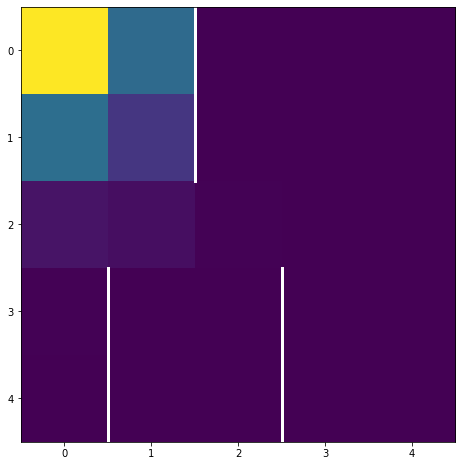

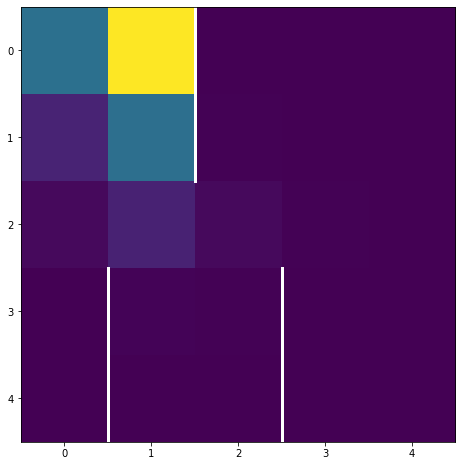

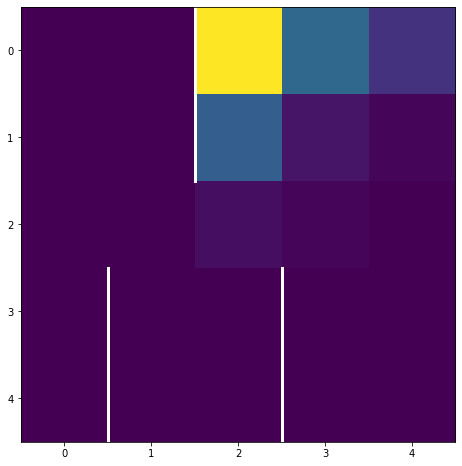

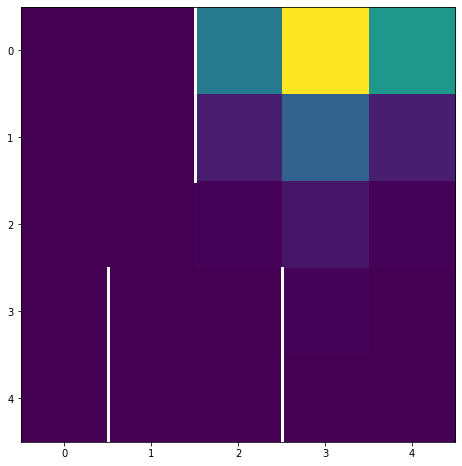

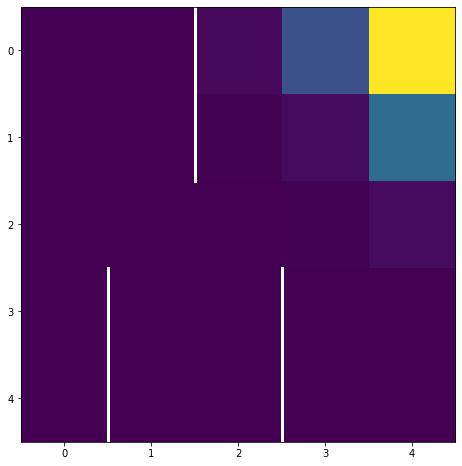

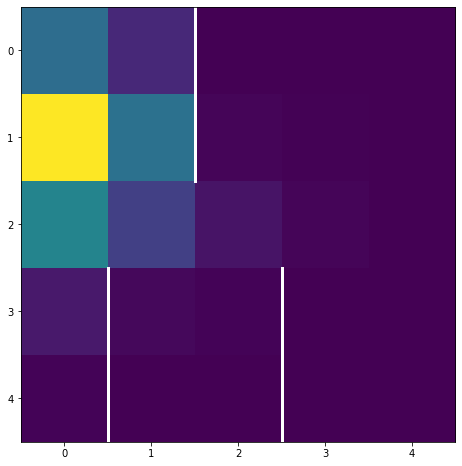

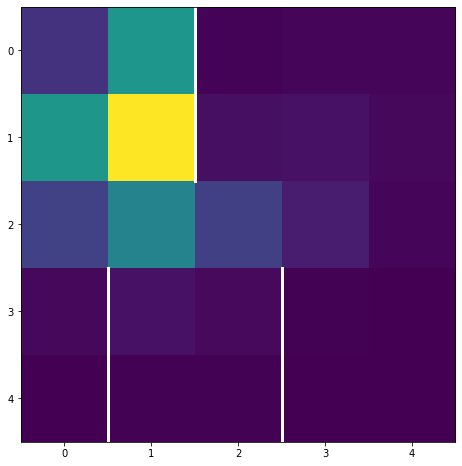

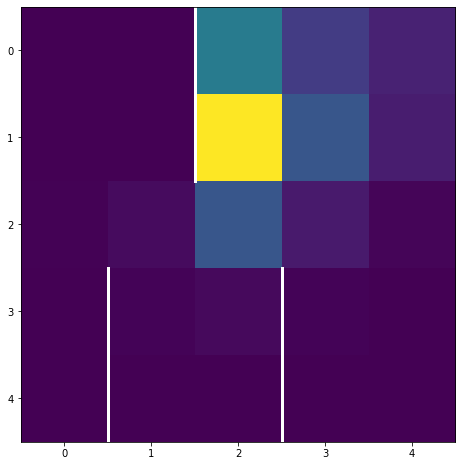

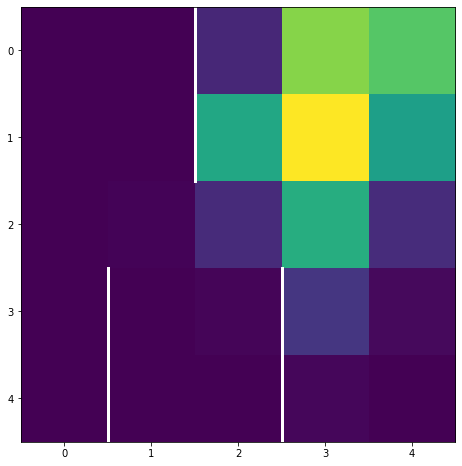

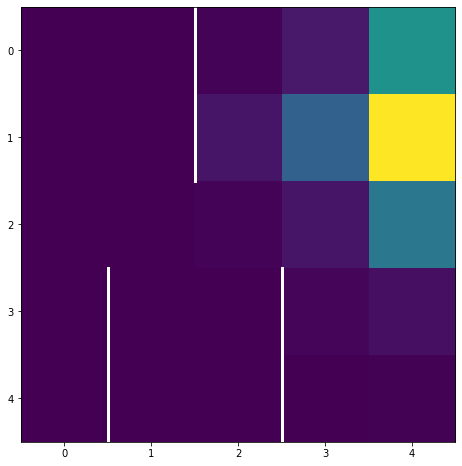

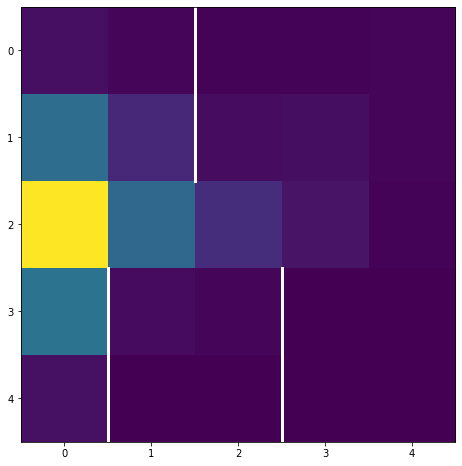

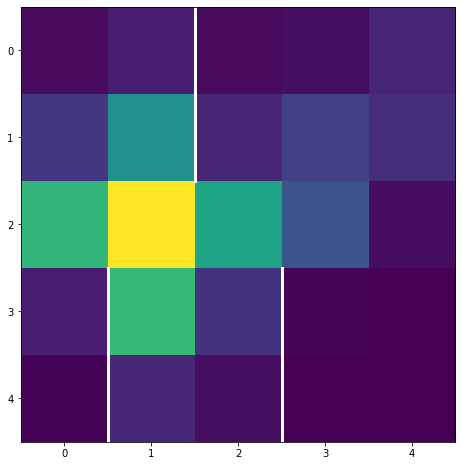

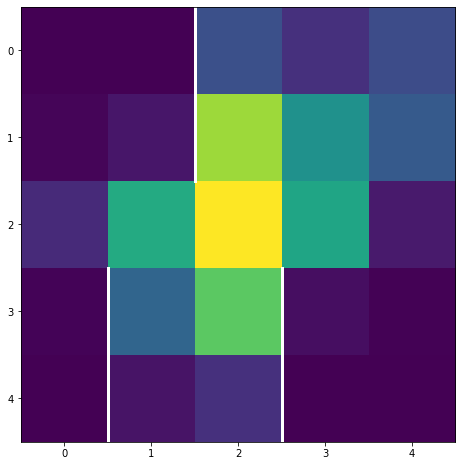

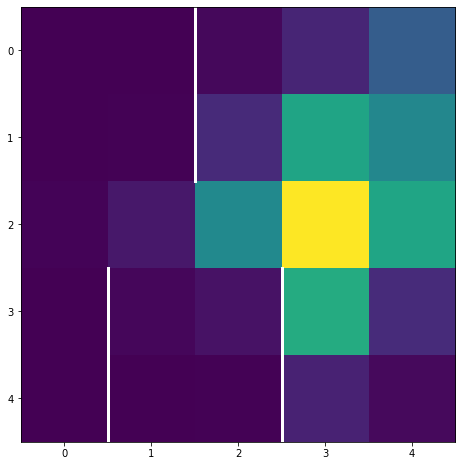

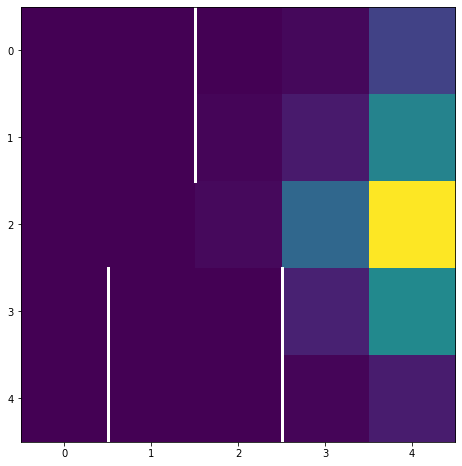

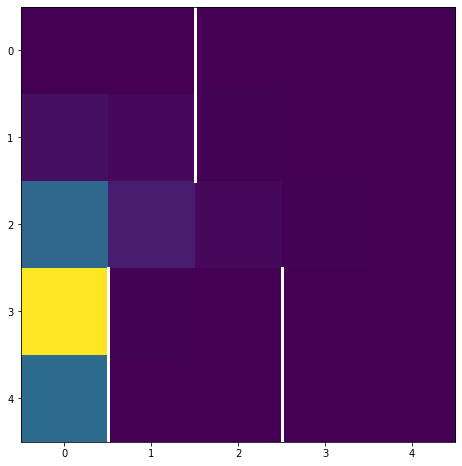

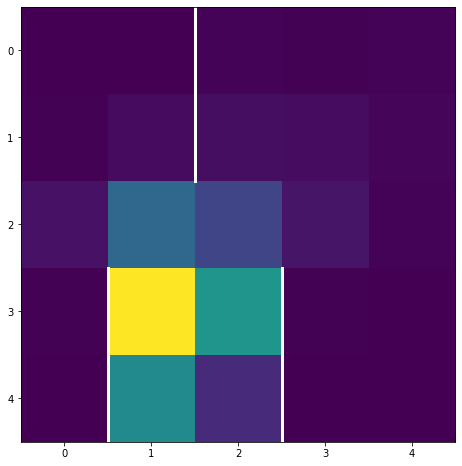

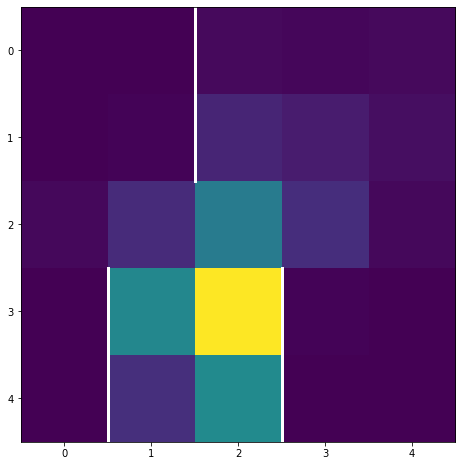

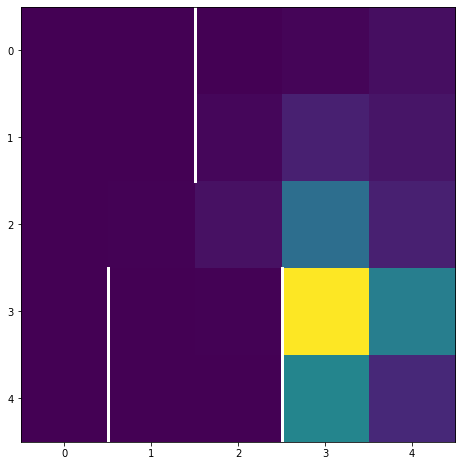

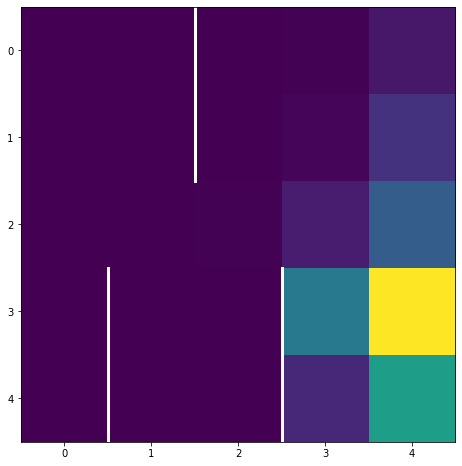

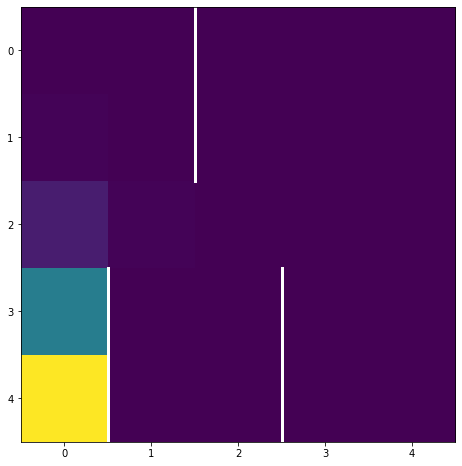

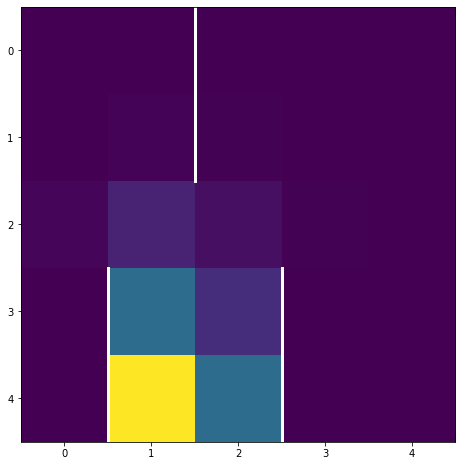

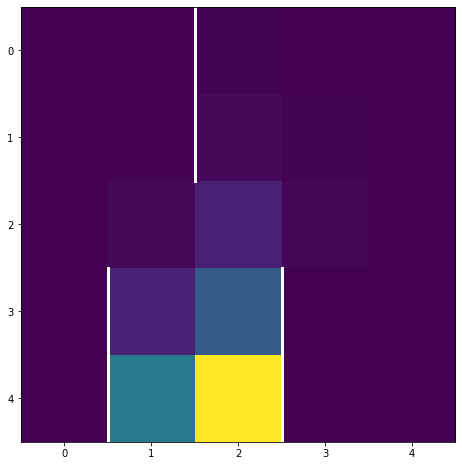

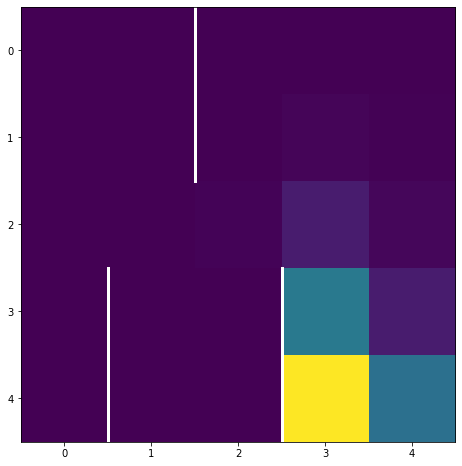

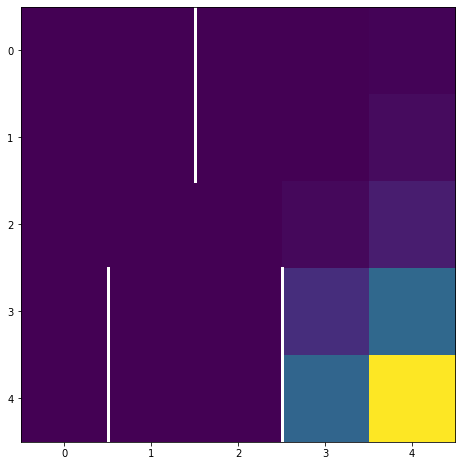

TypeError: 'AxesImage' object is not iterable

<Figure size 576x576 with 0 Axes>

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#fig, (ax1, ax2) = plt.subplots(1,2)
#fig, ax = plt.subplots(nrows=5, ncols=5, figsize = (10,10), dpi = 150)
 
#fig.suptitle('Stacked subplots in two direction')
ims = []

for i in range(5):
    for j in range(5):
        plt.figure(figsize = (8,8))
        #fig, ax = plt.subplots()
        sr_t = M_fixed[i*5+j,:].reshape(-1,5)
        plt.axvline(x = 1-0.5, ymax = 0.4,  color = 'white', label = 'axvline - full height', linewidth =3)
        plt.axvline(x = 2-0.5, ymin = 0.6,  color = 'white', label = 'axvline - full height', linewidth =3)
        plt.axvline(x = 3-0.5, ymax = 0.4,  color = 'white', label = 'axvline - full height', linewidth =3)
        im = plt.imshow(sr_t)
        plt.savefig(f'qq_{i}_{j}.png')
        #print(type(im))
        ims.append(im)


plt.show()
fig = plt.figure(figsize = (8,8))
ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=250)
ani.save('./sr_one.gif')
plt.show()



In [162]:
M_s = np.mean(agent.M[:,:,:], axis=0)
colors = np.zeros([500])
for bottleneck in env.bottlenecks:
    grid = np.zeros([env.grid_size,env.grid_size])
    grid[bottleneck[0],bottleneck[1]] = 1
    grid = grid.flatten()
    b_state = np.where(grid==1)[0][0]
    colors[b_state] = 1
pca = PCA(n_components=2)
pca_result = pca.fit_transform(M_s[:])

plt.scatter(pca_result[:,0], pca_result[:,1], c=colors)

AttributeError: 'TaxiEnv' object has no attribute 'bottlenecks'

In [108]:
250000/500

500.0

In [57]:
from IPython.display import Video
from IPython import display

def show_video(path):
    display(Video(path, embed=True))